In [25]:
from IPython.display import Image

# Why should you care about customer segmentation

- personalized experiences to customers : segmentation is Key

# 무엇을 만들것인가?

- 2*2 matrix를 만들어 4개의 customers group 생성

# 어떤 기준으로? RFM
- Recency : when was the last time purchased
- Frequency : How often and for how long have they purchased
- Monetary Value/Sales : How much have they purchased

#### R, M 만 사용 할 거임

# 데이터는?
- 갓갓 테블로에서 제공된 global superstore 데이터

# 어떤 방식으로 진행 할 거지!

- Load, filter, clean, aggregate data -> customer level
- Create RFM Feature for each customers
- Automate the segmentaion : 80% quantile for Recency and Monetray
    - kmean를 할수도 있지만.. 요거는 나중에 한번 해보자 
    - 개인적으로는 비 지도 학습 별루..
    

- Calculate RM score and sort customers
- Visualize the Value Matrix and explore some key numbers

# Step 0

In [7]:
!python3 -m pip install xlrd

In [8]:
import matplotlib as plt
import numpy as np
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [10]:
url = 'https://github.com/tristanga/Data-Analysis/raw/master/Global%20Superstore.xls'
df = pd.read_excel(url)
df = df[(df.Segment == 'Consumer') & (df.Country == 'United States')]
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
9,40936,CA-2012-116638,2012-01-28,2012-01-31,Second Class,JH-15985,Joseph Holt,Consumer,Concord,North Carolina,...,FUR-TA-10000198,Furniture,Tables,Chromcraft Bull-Nose Wood Oval Conference Tabl...,4297.644,13,0.4,-1862.3124,865.74,Critical
21,31784,CA-2011-154627,2011-10-29,2011-10-31,First Class,SA-20830,Sue Ann Reed,Consumer,Chicago,Illinois,...,TEC-PH-10001363,Technology,Phones,Apple iPhone 5S,2735.952,6,0.2,341.9940,752.51,High
32,32735,CA-2012-139731,2012-10-15,2012-10-15,Same Day,JE-15745,Joel Eaton,Consumer,Amarillo,Texas,...,FUR-CH-10002024,Furniture,Chairs,HON 5400 Series Task Chairs for Big and Tall,2453.430,5,0.3,-350.4900,690.42,High
34,32543,CA-2011-168494,2011-12-12,2011-12-14,Second Class,NP-18700,Nora Preis,Consumer,Fresno,California,...,FUR-TA-10003473,Furniture,Tables,Bretford Rectangular Conference Table Tops,3610.848,12,0.2,135.4068,683.12,High


# Step 1 : Create RFM Features for each customer 

In [11]:
df_RFM = df.groupby('Customer ID').agg({'Order Date': lambda y: (df['Order Date'].max().date() - y.max().date()).days,
                                        'Order ID': lambda y: len(y.unique()),  
                                        'Sales': lambda y: round(y.sum(),2)})
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']
df_RFM = df_RFM.sort_values('Monetary', ascending=False)
df_RFM.head()

,Recency,Frequency,Monetary
Customer ID,,,
RB-19360,96,6,15117.34
AB-10105,41,10,14473.57
KL-16645,47,12,14175.23
SC-20095,349,9,14142.33
HL-15040,43,6,12873.30


# Step 2: To automate the segmentation we will use 80% quantile 

In [13]:
# We will use the 80% quantile for each feature
quantiles = df_RFM.quantile(q=[0.8])
print(quantiles)
df_RFM['R']=np.where(df_RFM['Recency']<=int(quantiles.Recency.values), 2, 1)
df_RFM['F']=np.where(df_RFM['Frequency']>=int(quantiles.Frequency.values), 2, 1)
df_RFM['M']=np.where(df_RFM['Monetary']>=int(quantiles.Monetary.values), 2, 1)
df_RFM.head()

     Recency  Frequency  Monetary
0.8    222.2        8.0   4070.17


,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
RB-19360,96,6,15117.34,2,1,2
AB-10105,41,10,14473.57,2,2,2
KL-16645,47,12,14175.23,2,2,2
SC-20095,349,9,14142.33,1,2,2
HL-15040,43,6,12873.30,2,1,2


# Step 3: Calculate RFM score and sort customers


In [17]:
# To do the 2 x 2 matrix we will only use Recency & Monetary
df_RFM['RMScore'] = df_RFM.M.map(str)+df_RFM.R.map(str)
df_RFM = df_RFM.reset_index()
df_RFM_SUM = df_RFM.groupby('RMScore').agg({'Customer ID': lambda y: len(y.unique()),
                                        'Frequency': lambda y: round(y.mean(),0),
                                        'Recency': lambda y: round(y.mean(),0),
                                        'R': lambda y: round(y.mean(),0),
                                        'M': lambda y: round(y.mean(),0),
                                        'Monetary': lambda y: round(y.mean(),0)})
df_RFM_SUM = df_RFM_SUM.sort_values('RMScore', ascending=False)
df_RFM_SUM.head()


,Customer ID,Frequency,Recency,R,M,Monetary
RMScore,,,,,,
22,73,8.0,59.0,2.0,2.0,6711.0
21,9,7.0,425.0,1.0,2.0,8564.0
12,254,6.0,70.0,2.0,1.0,1902.0
11,73,4.0,440.0,1.0,1.0,1526.0


# Step 4: Visualize the Value Matrix and explore some key numbers


In [19]:
# 1) Average Monetary Matrix
df_RFM_M = df_RFM_SUM.pivot(index='M', columns='R', values='Monetary')
df_RFM_M= df_RFM_M.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_M

R,1.0,2.0
M,,
2.0,8564.0,6711.0
1.0,1526.0,1902.0


In [21]:
# 2) Number of Customer Matrix
df_RFM_C = df_RFM_SUM.pivot(index='M', columns='R', values='Customer ID')
df_RFM_C= df_RFM_C.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_C

R,1.0,2.0
M,,
2.0,9,73
1.0,73,254


In [22]:
# 3) Recency Matrix
df_RFM_R = df_RFM_SUM.pivot(index='M', columns='R', values='Recency')
df_RFM_R= df_RFM_R.reset_index().sort_values(['M'], ascending = False).set_index(['M'])
df_RFM_R

R,1.0,2.0
M,,
2.0,425.0,59.0
1.0,440.0,70.0


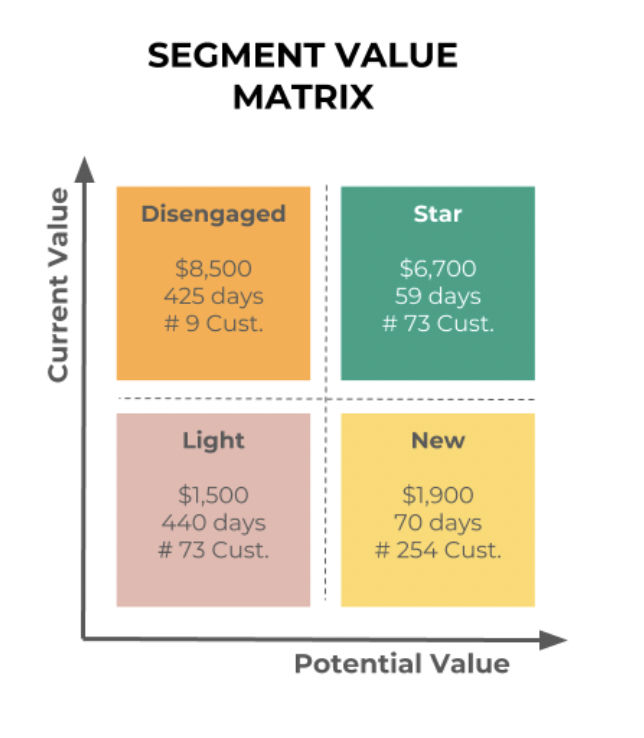

In [24]:
Image('./image/RFM.png')

Some takeaways / quick wins with very simple sales & marketing tactics examples?

The average last order from the “Light” bucket is very old (more than 1 year vs. 60-70 days for ‘engaged’ customers)